In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

You can download the dataset directly from the UCI Machine Learning Repository:

[Bank Marketing Dataset - UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/222/bank%2Bmarketing)

In [2]:
df = pd.read_csv('data/bank-full.csv', sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


There are `45211` rows and `17` columns in our dataset.

There are `7` numerical features and `10` categorical ones in our dataset.

There is no missing value in the dataset.

In [4]:
print(df['y'].value_counts())
print(df['y'].value_counts(normalize=True)*100)

y
no     39922
yes     5289
Name: count, dtype: int64
y
no     88.30152
yes    11.69848
Name: proportion, dtype: float64


The target variable is imbalanced.

##  EDA

In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


`age`: Starts from `18` and ends with `95`, which is resoanable. The median is `39` and the `meann` is `40`, so they are close to each other. Std is `10`, it shows us the vriability. It seems there are some too old people.

`balance`: Std is high so the variability is high as well. min is negetavie, we should check, if its resoanlabe. mean is much higher than median so it can be right-skewed. 

`day`: The range is from `1` to `31` which is reasonable. 

`duration`: The diffrence between max and 75% is too much so there are outliers(extreme high values). mean is bigger than medain so it can be right-skewed. 

`pdays`: mean is higher than median, can be right-skewed. There are negative values, so we should cjeck them.

`previous`: Max is much higher than 75%, can mean its right-skewed. Most clients have never been contacted before, so we should analyze its distribution further.

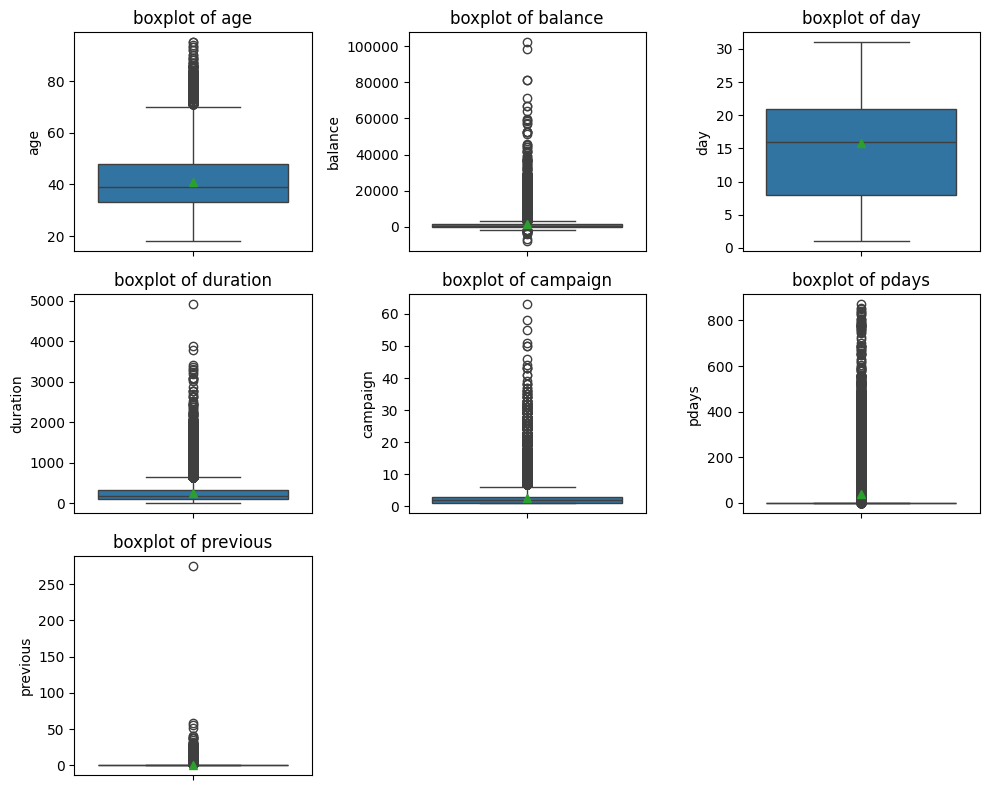

In [6]:
num_features = df.select_dtypes(include='int64')
plt.figure(figsize=(10,8))

for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(df[col], showmeans=True)
    plt.title(f'boxplot of {col}')

plt.tight_layout()
plt.show()

Based on the boxplot:

`day`: Seems normall.

`age`: There are outliers, some values are too high(old).

`balance`: There are outliers and some with very extreme values. There are negative values we should check.

`duration`: There are outliers.

`campagin`: There are outliers.

`pdays`: Some extreme values beyond 600-800, making it highly skewed. We should check how many times -1 appears and possibly separate it into a new category.

`previous`: Most values are near 0, but extreme values reach 275, meaning some people were contacted many times before. The distribution is highly skewed, so we may need transformations or binning.

In [7]:
df[df['balance']<0].shape[0]

3766

There are `3766` values as `-1` for `balance`.

In [8]:
df['pdays'].value_counts()

pdays
-1      36954
 182      167
 92       147
 183      126
 91       126
        ...  
 756        1
 745        1
 530        1
 749        1
 838        1
Name: count, Length: 559, dtype: int64

There are `36954` `pdays` with `-1` as their value.

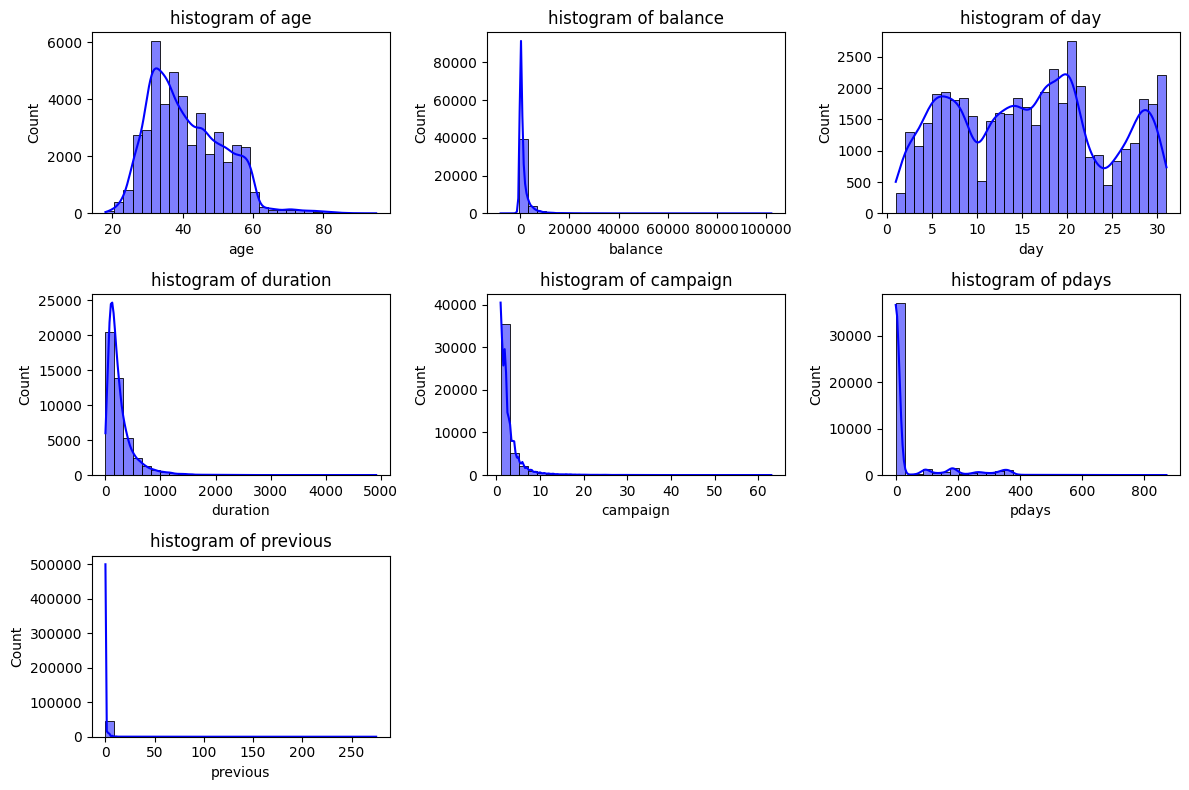

In [9]:
plt.figure(figsize=(12,8))

for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=30, kde=True, color='blue')
    plt.title(f'histogram of {col}')

plt.tight_layout()
plt.show()

Based on the Histograms:

`age`: Most of the ages are between `20` to `40`. There are some high values.

`balance`: Its right-skewed. Some have very high balance.

`day`: Its distributed uniformly.

`duration`: Its right-skewed. 

`campagin`: Its right-skewed.

`pdays`: Its right-skewed.

`previous`: Its right-skewed.

In [10]:
df[df['balance'] < 0]['balance'].describe()

count    3766.000000
mean     -317.677642
std       368.994983
min     -8019.000000
25%      -422.000000
50%      -230.000000
75%       -93.000000
max        -1.000000
Name: balance, dtype: float64

In [11]:
df.groupby('pdays')['y'].value_counts(normalize=True)

pdays  y  
-1     no     0.908427
       yes    0.091573
 1     no     0.600000
       yes    0.400000
 2     no     0.945946
                ...   
 838   no     1.000000
 842   yes    1.000000
 850   no     1.000000
 854   yes    1.000000
 871   no     1.000000
Name: proportion, Length: 914, dtype: float64

In [12]:
df.groupby('previous')['y'].value_counts(normalize=True)

previous  y  
0         no     0.908427
          yes    0.091573
1         no     0.789683
          yes    0.210317
2         no     0.783476
                   ...   
41        no     1.000000
51        no     1.000000
55        yes    1.000000
58        yes    1.000000
275       no     1.000000
Name: proportion, Length: 66, dtype: float64

In [13]:
df['balance_category'] = df['balance'].apply(lambda x: 'negative' if x < 0 else 'positive')
df.groupby('balance_category')['y'].value_counts(normalize=True)

balance_category  y  
negative          no     0.944238
                  yes    0.055762
positive          no     0.877452
                  yes    0.122548
Name: proportion, dtype: float64

In [14]:
df['pdays_category'] = df['pdays'].apply(lambda x: 'never_contacted' if x == -1 else 'contacted_before')
df.groupby('pdays_category')['y'].value_counts(normalize=True)

pdays_category    y  
contacted_before  no     0.769287
                  yes    0.230713
never_contacted   no     0.908427
                  yes    0.091573
Name: proportion, dtype: float64

In [15]:
df['previous_category'] = df['previous'].apply(lambda x: 'never_contacted' if x == 0 else ('few_times' if x <= 3 else 'many_times'))
df.groupby('previous_category')['y'].value_counts(normalize=True)

previous_category  y  
few_times          no     0.778571
                   yes    0.221429
many_times         no     0.744300
                   yes    0.255700
never_contacted    no     0.908427
                   yes    0.091573
Name: proportion, dtype: float64

## Feature Engineering

In [16]:
cat_features = df.select_dtypes(include='object')
cat_features.nunique()

job                  12
marital               3
education             4
default               2
housing               2
loan                  2
contact               3
month                12
poutcome              4
y                     2
balance_category      2
pdays_category        2
previous_category     3
dtype: int64

In [17]:
# One-Hot Encoding for Nominal Categorical Variables
ohe_columns = ["job", "marital", "contact", "month", "poutcome", "pdays_category", "previous_category", "balance_category"]
df = pd.get_dummies(df, columns=ohe_columns, drop_first=True)  # drop_first=True avoids multicollinearity

# Ordinal Encoding for Ordered Categories
education_order = ["unknown", "primary", "secondary", "tertiary"]
ordinal_encoder = OrdinalEncoder(categories=[education_order])
df["education"] = ordinal_encoder.fit_transform(df[["education"]])

# Binary Encoding for Yes/No Features
binary_columns = ["default", "housing", "loan", "y"]
for col in binary_columns:
    df[col] = df[col].map({"no": 0, "yes": 1})

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                45211 non-null  int64  
 1   education                          45211 non-null  float64
 2   default                            45211 non-null  int64  
 3   balance                            45211 non-null  int64  
 4   housing                            45211 non-null  int64  
 5   loan                               45211 non-null  int64  
 6   day                                45211 non-null  int64  
 7   duration                           45211 non-null  int64  
 8   campaign                           45211 non-null  int64  
 9   pdays                              45211 non-null  int64  
 10  previous                           45211 non-null  int64  
 11  y                                  45211 non-null  int

In [19]:
# Convert only boolean columns to integers (0 and 1)
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

In [20]:
# Selecting numerical features to scale
num_features_to_scale = ["age", "balance", "campaign"]

scaler = StandardScaler()

df[num_features_to_scale] = scaler.fit_transform(df[num_features_to_scale])

## Model Evaluate

In [21]:
X = df.drop(columns='y')
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(36168, 44)
(36168,)
(9043, 44)
(9043,)


In [22]:
log_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

log_model.fit(X_train, y_train)

log_y_pred = log_model.predict(X_test)

print(confusion_matrix(y_test, log_y_pred))
print(classification_report(y_test, log_y_pred))

[[6782 1203]
 [ 197  861]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7985
           1       0.42      0.81      0.55      1058

    accuracy                           0.85      9043
   macro avg       0.69      0.83      0.73      9043
weighted avg       0.91      0.85      0.86      9043



f:\AI Data Projects\Bank_Marketing _Campaign_Success_Prediction\bank_marketing\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


True Negatives (6782): Predicted "no" correctly.

False Positives (1203): Predicted "yes" incorrectly.

False Negatives (197): Missed actual "yes".

True Positives (861): Predicted "yes" correctly.

Precision & Recall:

Class 0 (No Subscription)

Precision: 97% (Very high)

Recall: 85% (Misses some true 'no' cases)

Class 1 (Subscription)

Precision: 42% (Low, means a lot of false positives)

Recall: 81% (Decent, means it captures most of the true 'yes')

F1-Score:

Class 0: 91% (Very good)

Class 1: 55% (Not great, needs improvement)

In [23]:
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)

print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))

[[7788  197]
 [ 643  415]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.68      0.39      0.50      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.68      0.72      9043
weighted avg       0.89      0.91      0.90      9043



Only 197 false positives → Much better than Logistic Regression (1203).

Missed 643 true "yes" cases → Recall for "yes" is low.

Precision & Recall:

Class 0 (No Subscription)

Precision: 92% (Very good)

Recall: 98% (Excellent)

Class 1 (Subscription)

Precision: 68% (Better than Logistic Regression’s 42%)

Recall: 39% (Lower than Logistic Regression’s 81%)

F1-Score

Class 0: 95% (Very strong)

Class 1: 50% (Better precision but still missing many true "yes" cases)

Accuracy & Weighted Average

Overall accuracy: 91% (Better than Logistic Regression’s 85%)

Macro avg F1-score: 72% (Balanced metric)

Weighted avg F1-score: 90%

In [24]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train Random Forest on SMOTE data
rf_smote_model = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_smote_model.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_smote = rf_smote_model.predict(X_test)

# Evaluate model performance
print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))

f:\AI Data Projects\Bank_Marketing _Campaign_Success_Prediction\bank_marketing\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
f:\AI Data Projects\Bank_Marketing _Campaign_Success_Prediction\bank_marketing\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "f:\AI Data Projects\Bank_Marketing _Campaign_Success_Prediction\bank_marketing\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info 

[[7629  356]
 [ 531  527]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7985
           1       0.60      0.50      0.54      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.73      0.74      9043
weighted avg       0.90      0.90      0.90      9043



Recall for "yes" (Subscription) improved (39% → 50%), meaning we are catching more real subscribers.

Precision for "yes" dropped (68% → 60%), meaning more false positives.

F1-score improved (50% → 54%), which balances precision & recall.

In [28]:
# Define hyperparameter grid
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    rf_model, param_dist, n_iter=10, cv=3, scoring='f1', random_state=42, n_jobs=-1, verbose=1
)

# Fit on SMOTE-balanced data
random_search.fit(X_train_smote, y_train_smote)

# Best model from tuning
best_rf = random_search.best_estimator_

# Make predictions on test set
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate model performance
print(confusion_matrix(y_test, y_pred_best_rf))
print(classification_report(y_test, y_pred_best_rf))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[[7564  421]
 [ 478  580]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7985
           1       0.58      0.55      0.56      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.75      0.75      9043
weighted avg       0.90      0.90      0.90      9043



Recall improved from 50% → 55% (More actual subscribers detected)

F1-score improved from 54% → 56% (Better balance of precision & recall)

Slight drop in precision from 60% → 58% (More false positives)

Tuning helped capture more real subscribers but slightly increased false positives.

In [31]:
# Initialize XGBoost model
xgb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=len(y_train_smote[y_train_smote == 0]) / len(y_train_smote[y_train_smote == 1]),
    use_label_encoder=False,
    eval_metric="logloss"
)

# Train the model on SMOTE-balanced data
xgb_model.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate model performance
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

f:\AI Data Projects\Bank_Marketing _Campaign_Success_Prediction\bank_marketing\lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[7584  401]
 [ 484  574]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7985
           1       0.59      0.54      0.56      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.75      0.75      9043
weighted avg       0.90      0.90      0.90      9043



XGBoost slightly improved precision (59% vs. 58%) → Fewer false positives.

Recall slightly dropped (54% vs. 55%) → Misses a few more true "yes" cases.

Overall, XGBoost and Random Forest are very close in performance.